# Pytorch Multi-output GPR

The purpose of this notebook is to predict the soil type and soil thickness of Layer 1 as a Multi-Output GP model using a ModelList. Unlike a Multi-Task model, Multi-Output models do not represent correlations between outcomes, but treat outcomes independently. 

#### Import libraries

In [1]:
!pip install torch --quiet
!pip install gpytorch --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import torch
import gpytorch
from gpytorch.models import ApproximateGP, ExactGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import SoftmaxLikelihood, GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

____________________

#### Load training data points

In [3]:
# Load the training data CSV file compiled in `1-data_access.ipynb`
input_file = '../data/2-uw_layer1_trainingdata.csv'
training_data = pd.read_csv(input_file)

# Create a GeoDataFrame from the DataFrame
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.points_from_xy(training_data.LONGITUDE, training_data.LATITUDE))
    
# Set the CRS to WGS84 (latitude and longitude)
training_data.set_crs(epsg=4326, inplace=True)

training_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30573 47.65672),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30684 47.65364),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30647 47.65377),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30664 47.65326),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30626 47.65371),Qvt,1.996012,9.385303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,143845,MW-1,Geotechnical,42.0,217.4,47.661044,-122.342453,1,0.0,7.5,SM,S,7.5,POINT (-122.34245 47.66104),Qvr,1.594538,10.106370
502,143846,MW-2,Geotechnical,43.0,218.2,47.661138,-122.342516,1,0.0,7.5,SM,S,7.5,POINT (-122.34252 47.66114),Qvr,1.340698,8.735672
503,143847,MW-3,Geotechnical,45.5,219.3,47.661276,-122.342492,1,0.0,18.0,SM,S,18.0,POINT (-122.34249 47.66128),Qvr,1.594538,10.106370
504,143848,MW-4,Geotechnical,43.0,219.1,47.661177,-122.342383,1,0.0,10.0,SM,S,10.0,POINT (-122.34238 47.66118),Qvr,1.594538,10.106370


____________________

#### Split train and test data

In [4]:
# Assuming training_data is your DataFrame
X = training_data[['MAPPED_UNIT', 'SLOPE', 'ROUGHNESS']]
y_1 = training_data['SIMPLE_USCS']
y_2 = training_data['LAYER_THICKNESS_FT']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['MAPPED_UNIT']),  # One-hot encode categorical features
        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
    ])

# Apply transformations and convert to dense array
X_processed = preprocessor.fit_transform(X).toarray()  # Convert to array if sparse

# Convert processed data to tensors
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
## When dataset gets large and the one-hot encoding results in a sparse matrix, consider using a sparse tensor in PyTorch. This can help with memory efficiency
# X_tensor = torch.tensor(X_processed.todense(), dtype=torch.float32) if scipy.sparse.issparse(X_processed) else torch.tensor(X_processed, dtype=torch.float32) 

# Handling target for SIMPLE_USCS
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1) # Ensure target is in integer form
y_1_tensor = torch.tensor(y_1_encoded, dtype=torch.long) # Convert to tensor

# Handling target for LAYER_THICKNESS_FT
scaler = StandardScaler()
y_2_scaled = scaler.fit_transform(y_2.values.reshape(-1, 1))
y_2_tensor = torch.tensor(y_2_scaled, dtype=torch.float32).squeeze() 

# Split the data into training and test sets for both models
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_tensor, y_1_tensor, test_size=0.2, random_state=42, stratify=y_1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_2_tensor, test_size=0.2, random_state=42)

In [5]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x, num_classes):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution, learn_inducing_locations=True)
        super(GPClassificationModel, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.num_classes = num_classes

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x).expand([self.num_classes])

In [6]:
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [7]:
# Initialize the likelihood and model for multiclass classification
num_classes = len(label_encoder.classes_)
likelihood_1 = gpytorch.likelihoods.SoftmaxLikelihood(num_classes=num_classes, mixing_weights=None)
model_1 = GPClassificationModel(X_train_1, num_classes=num_classes)

# Initialize the likelihood and model for regression
likelihood_2 = GaussianLikelihood()
model_2 = GPRegressionModel(X_train_2, y_train_2, likelihood_2)

In [8]:
# Use a ModuleList to store the models
models = torch.nn.ModuleList([model_1, model_2])
likelihoods = torch.nn.ModuleList([likelihood_1, likelihood_2])

# Set into eval mode for all models and likelihoods
models.eval()
likelihoods.eval()

ModuleList(
  (0): SoftmaxLikelihood()
  (1): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)

In [9]:
# Training settings
training_iter = 1000  # Number of training iterations
lr = 0.001  # Learning rate

model_1.train()
likelihood_1.train()

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
mll_1 = gpytorch.mlls.VariationalELBO(likelihood_1, model_1, num_data=X_train_1.size(0))

# Implement Gradient Clipping
for i in range(training_iter):
    optimizer_1.zero_grad()
    output_1 = model_1(X_train_1)
    
    # Check for NaNs in the output
    if torch.isnan(output_1.mean).any():
        print(f"Warning: NaN detected in output at iteration {i + 1}")
        break
    
    loss_1 = -mll_1(output_1, y_train_1)
    loss_1.backward()
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)
    
    optimizer_1.step()
    print(f'Classification Model Iter {i + 1}/{training_iter} - Loss: {loss_1.item()}')

# Make predictions after training
model_1.eval()
likelihood_1.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood_1(model_1(X_test_1)).mean

# Check for NaN predictions
if torch.isnan(predictions).any():
    print("NaN detected in predictions!")
else:
    print("Predictions are valid.")

Classification Model Iter 1/1000 - Loss: 2.0522050857543945
Classification Model Iter 2/1000 - Loss: 2.0766382217407227
Classification Model Iter 3/1000 - Loss: 2.0534520149230957
Classification Model Iter 4/1000 - Loss: 2.0422394275665283
Classification Model Iter 5/1000 - Loss: 2.0544369220733643
Classification Model Iter 6/1000 - Loss: 2.0497450828552246
Classification Model Iter 7/1000 - Loss: 2.048713207244873
Classification Model Iter 8/1000 - Loss: 2.0540361404418945
Classification Model Iter 9/1000 - Loss: 2.0719716548919678
Classification Model Iter 10/1000 - Loss: 2.041654586791992
Classification Model Iter 11/1000 - Loss: 2.043761730194092
Classification Model Iter 12/1000 - Loss: 2.0168843269348145
Classification Model Iter 13/1000 - Loss: 2.068669557571411
Classification Model Iter 14/1000 - Loss: 2.033506155014038
Classification Model Iter 15/1000 - Loss: 2.044569253921509
Classification Model Iter 16/1000 - Loss: 2.042430877685547
Classification Model Iter 17/1000 - Loss

In [10]:
# Set models and likelihoods to evaluation mode
model_1.eval()
likelihood_1.eval()

# Make predictions (use a small batch from X_test_1 for diagnosis)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    small_X_test_1 = X_test_1[:5]  # Take the first 5 samples for a small test
    prediction = model_1(small_X_test_1)
    
    # Inspect the raw prediction mean before applying softmax
    print(f"Raw prediction mean (pre-softmax): {prediction.mean}")

    # Apply softmax and check the outputs
    predicted_probabilities = torch.softmax(prediction.mean, dim=0)
    print(f"Predicted probabilities: {predicted_probabilities}")

    predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()
    print(f"Predicted labels: {predicted_labels}")

# If everything seems fine in the small batch, proceed with the full prediction
if not torch.isnan(prediction.mean).any():
    print("Small batch predictions are valid, proceeding with full test set.")
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        full_prediction = model_1(X_test_1)
        full_predicted_probabilities = torch.softmax(full_prediction.mean, dim=0)
        if torch.isnan(full_predicted_probabilities).any():
            print("NaN detected in full predictions!")
        else:
            full_predicted_labels = full_predicted_probabilities.argmax(dim=0).detach().numpy()
            print(f"Full predicted labels: {full_predicted_labels}")
else:
    print("NaN detected in small batch predictions!")


Raw prediction mean (pre-softmax): tensor([[-0.0029, -0.0029, -0.0029, -0.0029, -0.0029],
        [-0.0029, -0.0029, -0.0029, -0.0029, -0.0029],
        [-0.0029, -0.0029, -0.0029, -0.0029, -0.0029],
        [-0.0029, -0.0029, -0.0029, -0.0029, -0.0029],
        [-0.0029, -0.0029, -0.0029, -0.0029, -0.0029],
        [-0.0029, -0.0029, -0.0029, -0.0029, -0.0029]])
Predicted probabilities: tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
Predicted labels: [0 0 0 0 0]
Small batch predictions are valid, proceeding with full test set.
Full predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [11]:
# Regression Model Training
model_2.train()
likelihood_2.train()

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.1)
mll_2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_2, model_2)

for i in range(training_iter):
    optimizer_2.zero_grad()
    output_2 = model_2(X_train_2)
    
    # Calculate loss
    loss_2 = -mll_2(output_2, y_train_2)
    
    loss_2.backward()
    optimizer_2.step()
    print(f'Regression Model Iter {i + 1}/{training_iter} - Loss: {loss_2.item()}')

Regression Model Iter 1/1000 - Loss: 1.4381760358810425
Regression Model Iter 2/1000 - Loss: 1.4281190633773804
Regression Model Iter 3/1000 - Loss: 1.4214415550231934
Regression Model Iter 4/1000 - Loss: 1.4173907041549683
Regression Model Iter 5/1000 - Loss: 1.4154865741729736
Regression Model Iter 6/1000 - Loss: 1.4150786399841309
Regression Model Iter 7/1000 - Loss: 1.4154598712921143
Regression Model Iter 8/1000 - Loss: 1.4160370826721191
Regression Model Iter 9/1000 - Loss: 1.4164316654205322
Regression Model Iter 10/1000 - Loss: 1.4164797067642212
Regression Model Iter 11/1000 - Loss: 1.416170597076416
Regression Model Iter 12/1000 - Loss: 1.415573000907898
Regression Model Iter 13/1000 - Loss: 1.4147820472717285
Regression Model Iter 14/1000 - Loss: 1.413895606994629
Regression Model Iter 15/1000 - Loss: 1.4130122661590576
Regression Model Iter 16/1000 - Loss: 1.4122291803359985
Regression Model Iter 17/1000 - Loss: 1.411615014076233
Regression Model Iter 18/1000 - Loss: 1.4111

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/srv/conda/envs/notebook/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


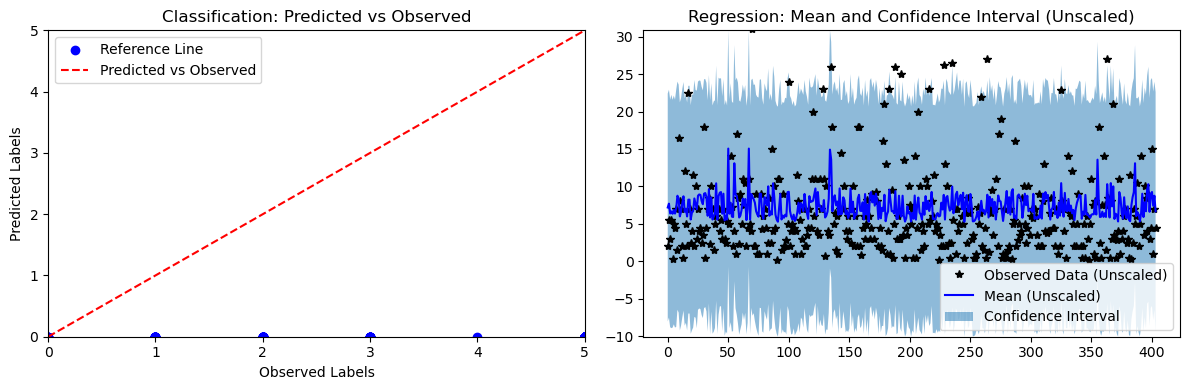

In [12]:
# Set models and likelihoods to evaluation mode
model_1.eval()
model_2.eval()
likelihood_1.eval()
likelihood_2.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(12, 4))

# Make predictions (use the test tensors X_train_1 and X_train_2)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = [likelihood(model(X_train)) for model, likelihood, X_train in zip(models, likelihoods, [X_train_1, X_train_2])]

# Iterate through the models and predictions
for i, (submodel, prediction, ax) in enumerate(zip(models, predictions, axs)):
    if i == 0:  # Classification Model
        predicted_probabilities = torch.softmax(prediction.mean, dim=0)  # Apply softmax across the class dimension
        predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()  # Use argmax on the class dimension
        print(predicted_probabilities)
        print(predicted_labels)
        
        # Ensure y_train_1 is flattened to match the predicted_labels shape
        y_train_1_flat = y_train_1.numpy().flatten()

        # Plot Predicted vs Observed labels
        if y_train_1_flat.shape == predicted_labels.shape:
            ax.scatter(y_train_1_flat, predicted_labels, c='b', marker='o')  # Scatter plot of predicted vs observed
            ax.plot([0, len(label_encoder.classes_) - 1], [0, len(label_encoder.classes_) - 1], 'r--')  # Diagonal line for reference
            ax.set_title('Classification: Predicted vs Observed')
            ax.set_xlabel('Observed Labels')
            ax.set_ylabel('Predicted Labels')
            ax.set_xlim([0, len(label_encoder.classes_) - 1])
            ax.set_ylim([0, len(label_encoder.classes_) - 1])
            ax.legend(['Reference Line', 'Predicted vs Observed'])
        else:
            print("Warning: Shapes of y_train_1 and predicted_labels do not match!")

    else:  # Regression Model
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

        # Reverse the standardization for the mean and confidence intervals
        mean_unscaled = scaler.inverse_transform(mean.numpy().reshape(-1, 1)).flatten()
        lower_unscaled = scaler.inverse_transform(lower.numpy().reshape(-1, 1)).flatten()
        upper_unscaled = scaler.inverse_transform(upper.numpy().reshape(-1, 1)).flatten()
        y_train_unscaled = scaler.inverse_transform(y_train_2.numpy().reshape(-1, 1)).flatten()

        # Plot the unscaled test data and predictions
        ax.plot(range(len(y_train_unscaled)), y_train_unscaled, 'k*')  # Plot the unscaled test targets
        ax.plot(range(len(mean_unscaled)), mean_unscaled, 'b')  # Unscaled predictive mean as blue line
        # Shade in confidence interval
        ax.fill_between(range(len(mean_unscaled)), lower_unscaled, upper_unscaled, alpha=0.5)
        ax.set_ylim([min(lower_unscaled), max(upper_unscaled)])  # Adjust the y-axis limits
        ax.set_title('Regression: Mean and Confidence Interval (Unscaled)')
        ax.legend(['Observed Data (Unscaled)', 'Mean (Unscaled)', 'Confidence Interval'])

plt.tight_layout()
plt.show()

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


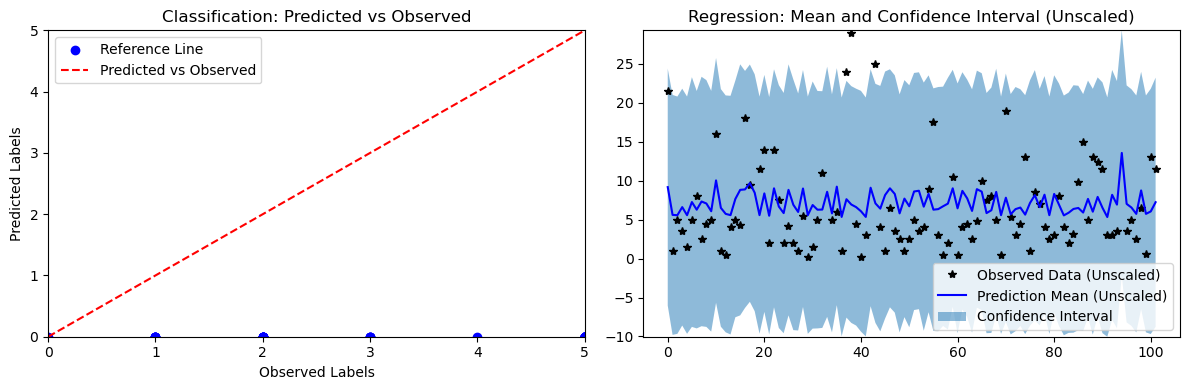

In [13]:
# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(12, 4))

# Make predictions (use the test tensors X_test_1 and X_test_2)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = [likelihood(model(X_test)) for model, likelihood, X_test in zip(models, likelihoods, [X_test_1, X_test_2])]

# Iterate through the models and predictions
for i, (submodel, prediction, ax) in enumerate(zip(models, predictions, axs)):
    if i == 0:  # Classification Model
        predicted_probabilities = torch.softmax(prediction.mean, dim=0)  # Apply softmax across the class dimension
        predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()  # Use argmax on the class dimension
        print(predicted_probabilities)
        print(predicted_labels)

        # Ensure y_test_1 is flattened to match the predicted_labels shape
        y_test_1_flat = y_test_1.numpy().flatten()

        # Plot Predicted vs Observed labels
        if y_test_1_flat.shape == predicted_labels.shape:
            ax.scatter(y_test_1_flat, predicted_labels, c='b', marker='o')  # Scatter plot of predicted vs observed
            ax.plot([0, len(label_encoder.classes_) - 1], [0, len(label_encoder.classes_) - 1], 'r--')  # Diagonal line for reference
            ax.set_title('Classification: Predicted vs Observed')
            ax.set_xlabel('Observed Labels')
            ax.set_ylabel('Predicted Labels')
            ax.set_xlim([0, len(label_encoder.classes_) - 1])
            ax.set_ylim([0, len(label_encoder.classes_) - 1])
            ax.legend(['Reference Line', 'Predicted vs Observed'])
        else:
            print("Warning: Shapes of y_test_1 and predicted_labels do not match!")

    else:  # Regression Model
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

        # Reverse the standardization for the mean and confidence intervals
        mean_unscaled = scaler.inverse_transform(mean.numpy().reshape(-1, 1)).flatten()
        lower_unscaled = scaler.inverse_transform(lower.numpy().reshape(-1, 1)).flatten()
        upper_unscaled = scaler.inverse_transform(upper.numpy().reshape(-1, 1)).flatten()
        y_test_unscaled = scaler.inverse_transform(y_test_2.numpy().reshape(-1, 1)).flatten()

        # Plot the unscaled test data and predictions
        ax.plot(range(len(y_test_unscaled)), y_test_unscaled, 'k*')  # Plot the unscaled test targets
        ax.plot(range(len(mean_unscaled)), mean_unscaled, 'b')  # Unscaled predictive mean as blue line
        # Shade in confidence interval
        ax.fill_between(range(len(mean_unscaled)), lower_unscaled, upper_unscaled, alpha=0.5)
        ax.set_ylim([min(lower_unscaled), max(upper_unscaled)])  # Adjust the y-axis limits
        ax.set_title('Regression: Mean and Confidence Interval (Unscaled)')
        ax.legend(['Observed Data (Unscaled)', 'Prediction Mean (Unscaled)', 'Confidence Interval'])

plt.tight_layout()
plt.show()

____________________

Sources:
1. https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/ModelList_GP_Regression.html
2. https://jamesbrind.uk/posts/2d-gaussian-process-regression/